## Finding the Efficient Frontier using Monte Carlo simulations

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

2. Set up the parameters:

In [5]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
# RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS = ['BTC-USD', 'ETH-USD', 'WAVES-USD', 'XEM-USD', 'ADA-USD', 'LBC-USD','XMR-USD', 'BNB-USD', 'OMG-USD', 
                   'MTL-USD']
RISKY_ASSETS.sort()
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [6]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  10 of 10 completed
Downloaded 362 rows of data.


In [7]:
# prices_df['Close']

In [8]:
# prices_df['Adj Close'].plot(title='Stock prices of the considered assets');

4. Calculate annualized average returns and the corresponding standard deviation:

In [9]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [10]:
# returns_df.plot(title='Daily returns of the considered assets');

5. Simulate random portfolio weights:

In [11]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate portfolio metrics:

In [12]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a joint DataFrame with all data:

In [13]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

8. Locate the points creating the Efficient Frontier:

In [14]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

9. Plot the Efficient Frontier:

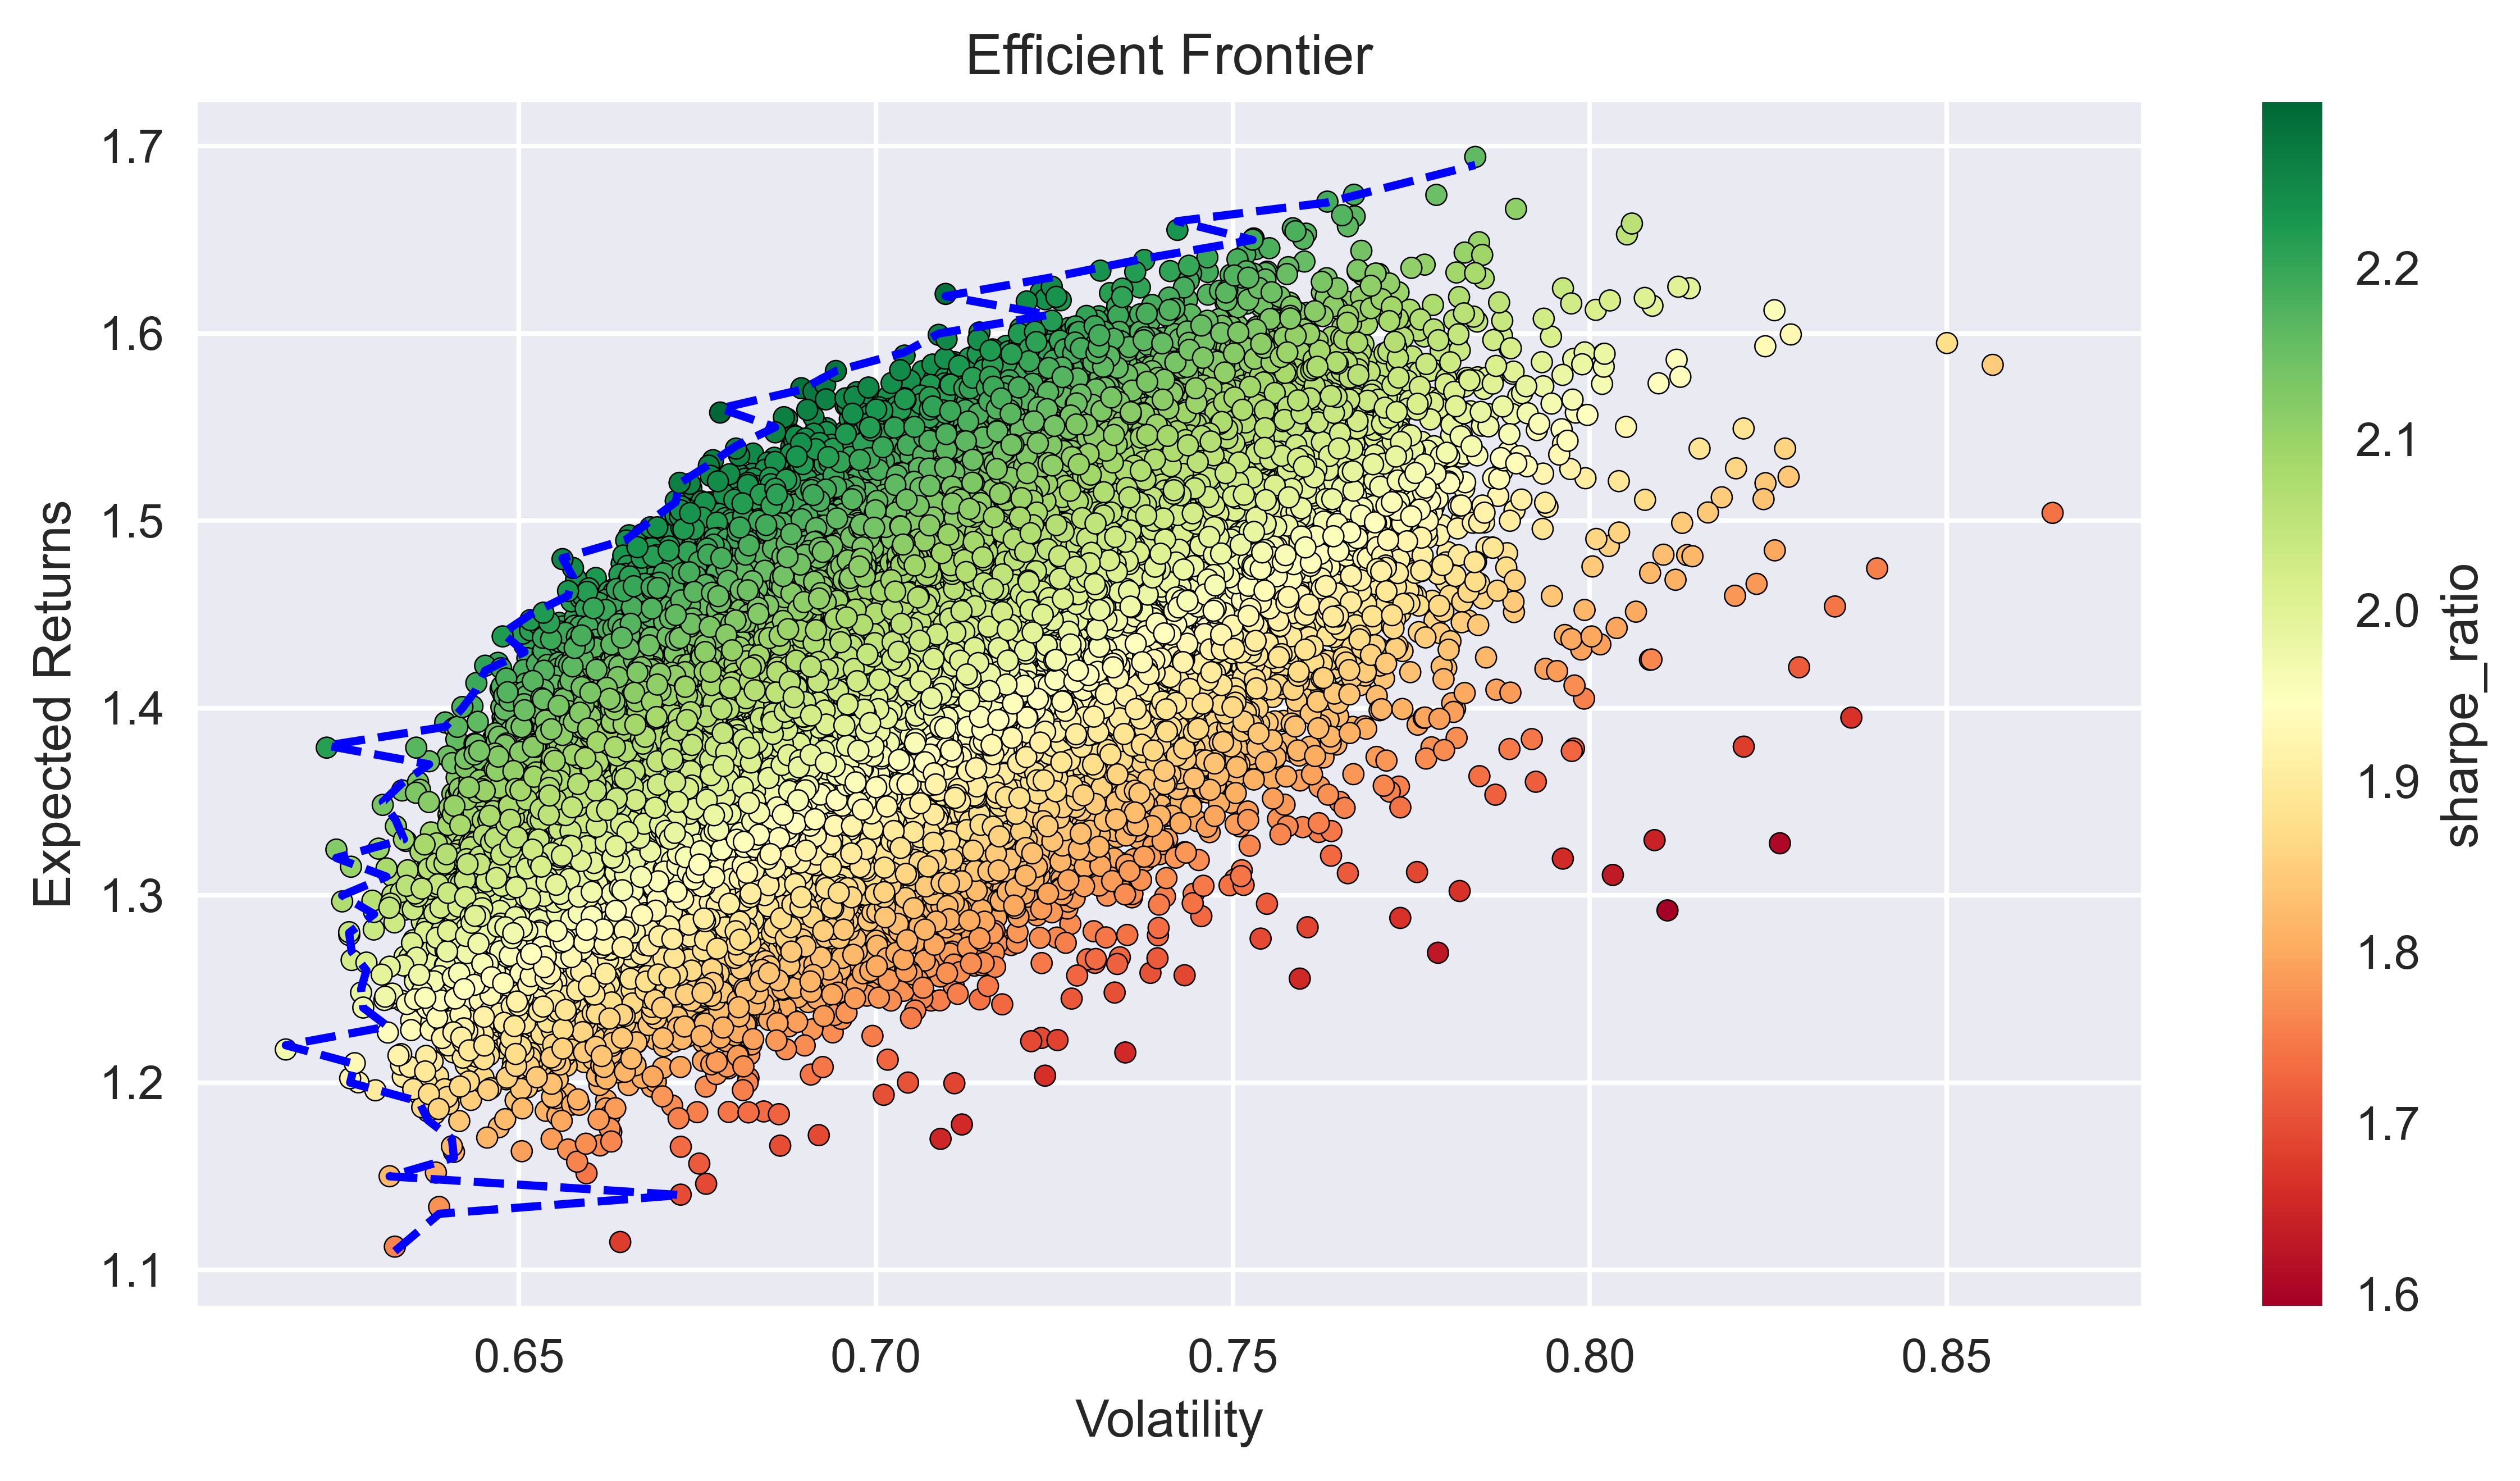

In [15]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
# for asset_index in range(n_assets):
#     ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
#                 y=avg_returns[asset_index], 
#                 marker=MARKS[asset_index], 
#                 s=150, 
#                 color='black',
#                 label=RISKY_ASSETS[asset_index])
# ax.legend()

plt.tight_layout()
# plt.savefig('images/ch7_im8.png')
plt.show()

### There's more

In [45]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [46]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 155.78% volatility: 67.82% sharpe_ratio: 229.71% 
Weights
ADA-USD: 7.41% BNB-USD: 0.07% BTC-USD: 22.76% ETH-USD: 18.16% LBC-USD: 3.02% MTL-USD: 1.88% OMG-USD: 1.36% WAVES-USD: 19.50% XEM-USD: 24.54% XMR-USD: 1.30% 

In [47]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 121.77% volatility: 61.73% sharpe_ratio: 197.26% 
Weights
ADA-USD: 1.76% BNB-USD: 6.97% BTC-USD: 28.17% ETH-USD: 2.52% LBC-USD: 6.65% MTL-USD: 22.62% OMG-USD: 0.22% WAVES-USD: 4.10% XEM-USD: 13.94% XMR-USD: 13.04% 

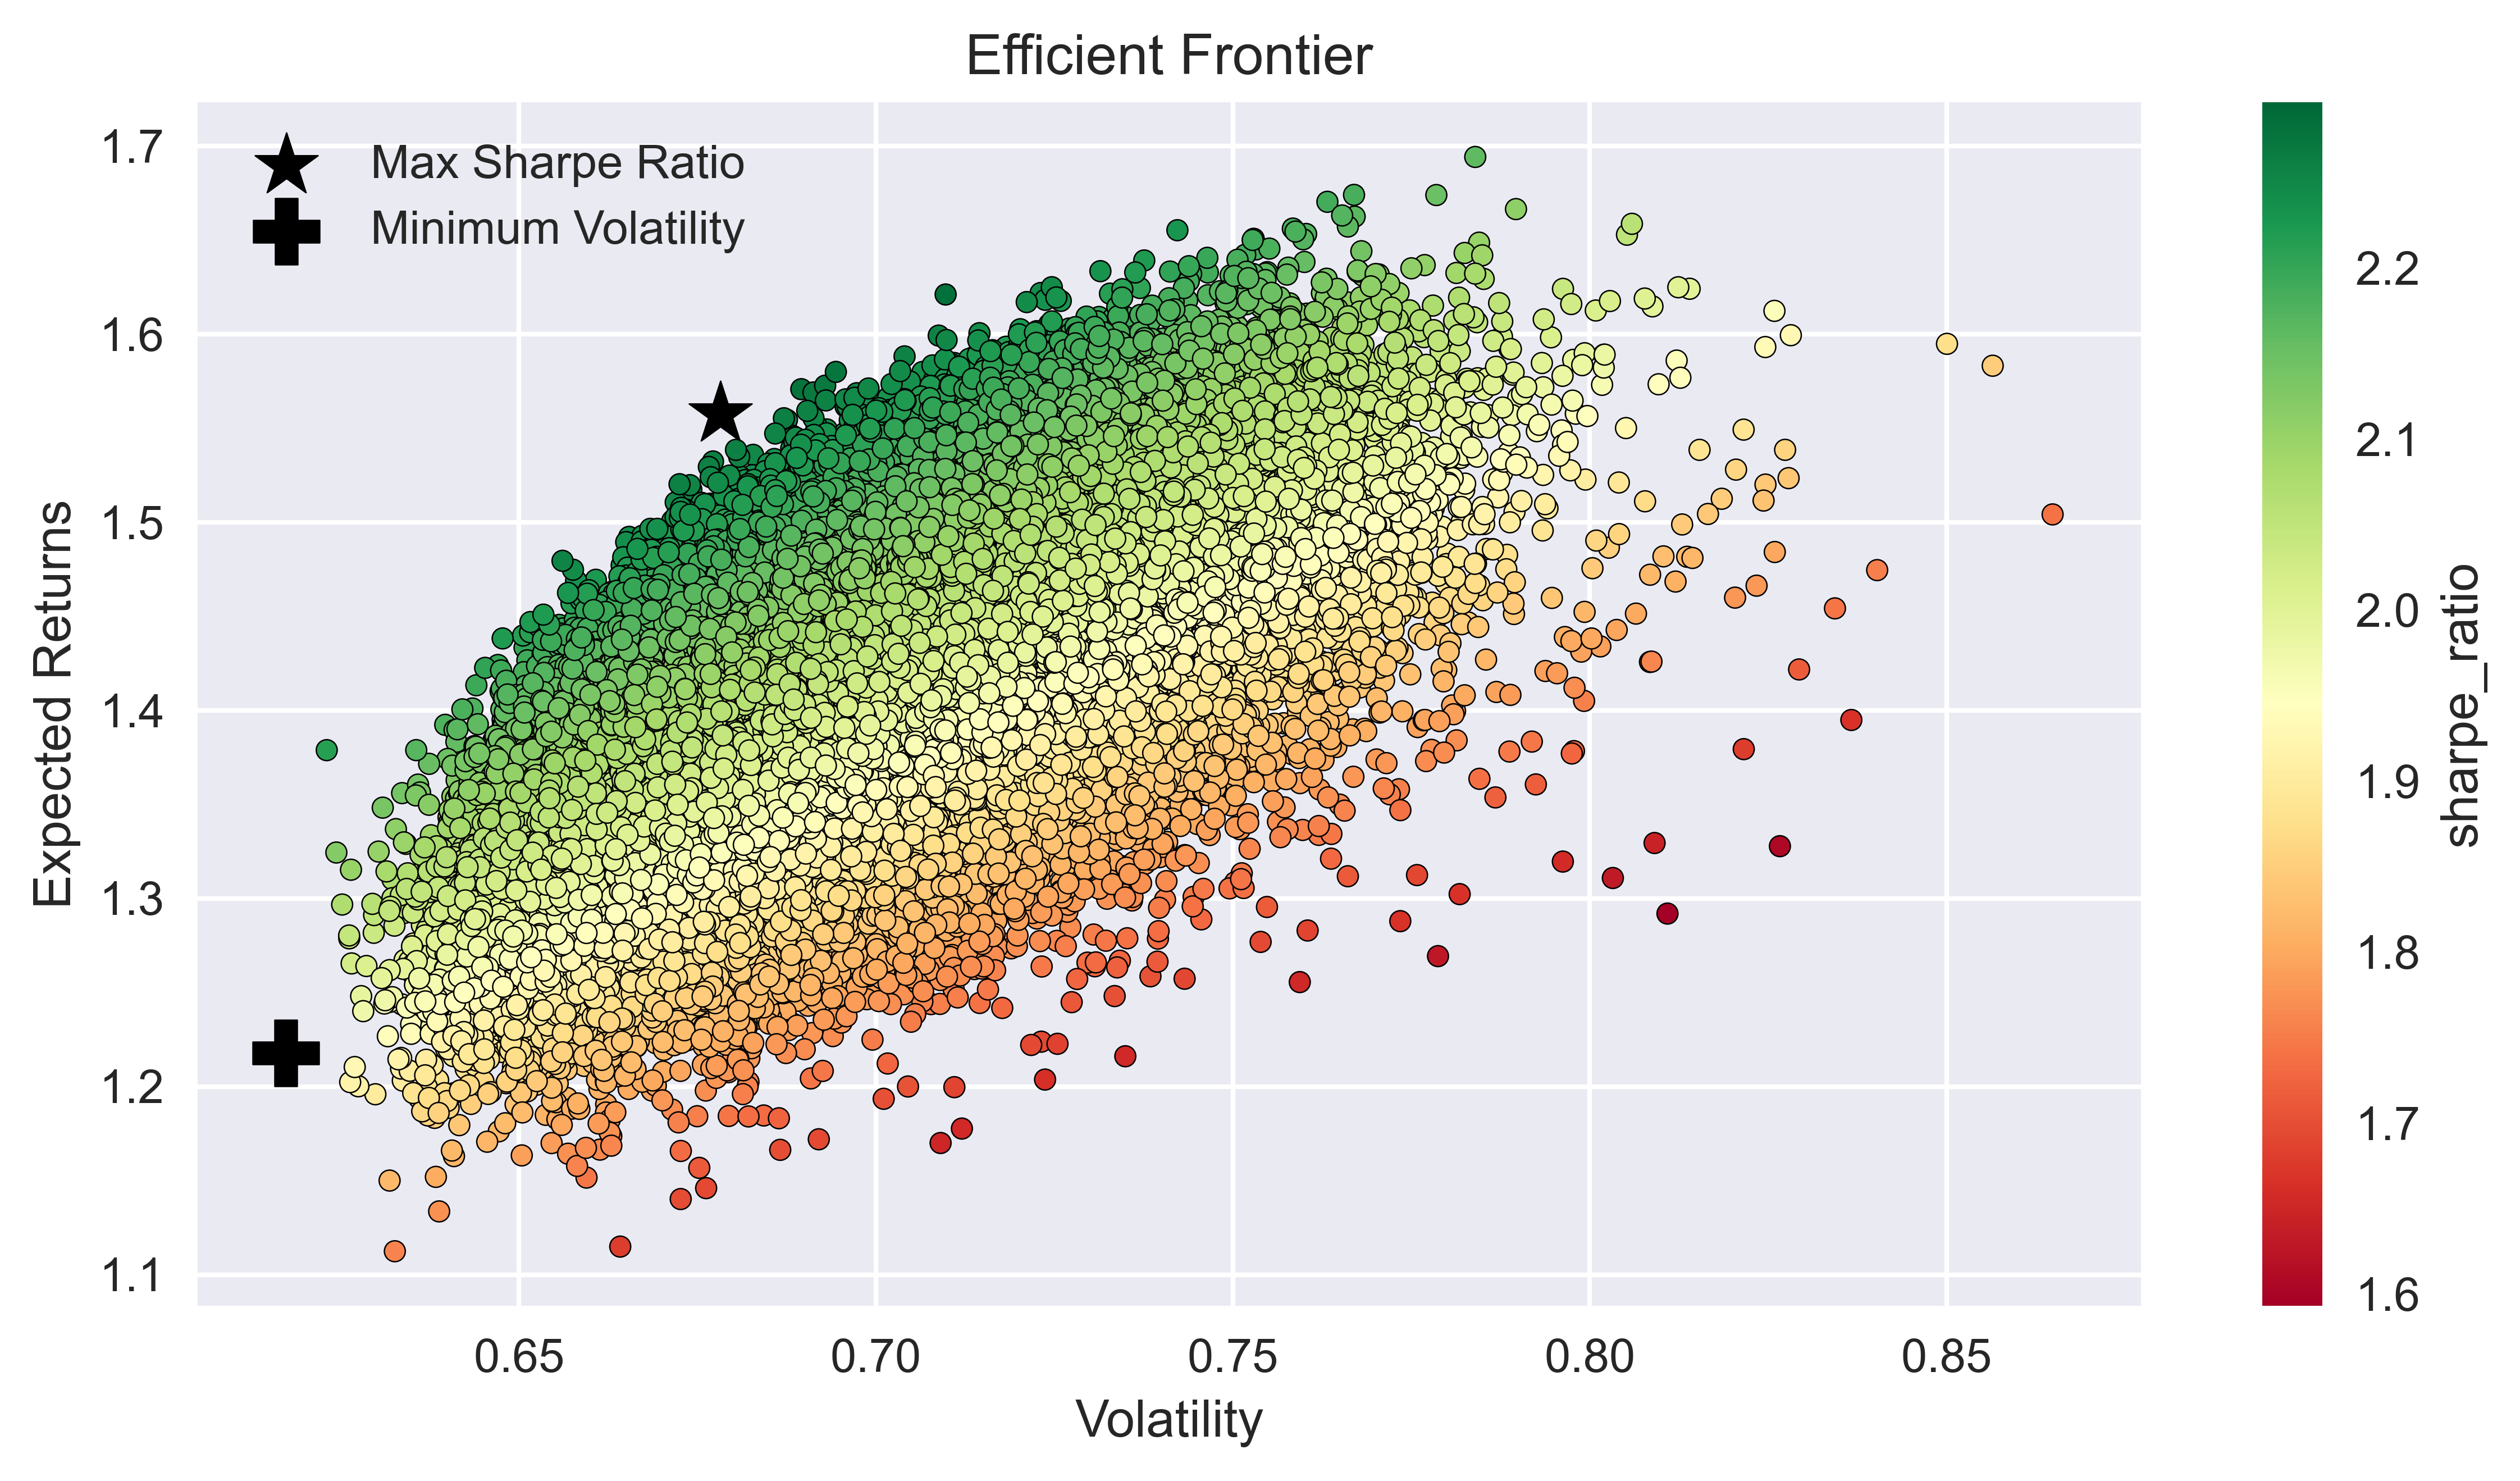

In [48]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
# plt.savefig('images/ch7_im11.png')
plt.show()

# From this point on, its u

## Finding the Efficient Frontier using optimization with scipy

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations*.

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
import scipy.optimize as sco

2. Define functions calculating portfolio returns and volatility:

In [ ]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

3. Define the function calculating the efficient frontier:

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

4. Define the considered range of returns:

In [ ]:
rtns_range = np.linspace(-0.22, 0.32, 200)

5. Calculate the Efficient Frontier:

In [ ]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.tight_layout()
plt.savefig('images/ch7_im12.png')
plt.show()

8. Identify the minimum volatility portfolio:

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

9. Print performance summary:

In [ ]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

### There's more

1. Define the objective function:

In [ ]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

2. Find the optimized portfolio:

In [ ]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

3. Extract information about the maximum Sharpe Ratio portfolio:

In [ ]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

4. Print performance summary:

In [ ]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

## Finding the Efficient Frontier using convex optimization with cvxpy

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with scipy*

### How to do it...

1. Import the libraries:

In [ ]:
import cvxpy as cp

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [ ]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

3. Set up the optimization problem:

In [ ]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

4. Calculate the Efficient Frontier:

In [ ]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

5. Plot the allocation for different values of the risk-aversion parameter:

In [ ]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=RISKY_ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig('images/ch7_im15.png')
plt.show()

6. Plot the Efficient Frontier, together with the individual assets:

In [ ]:
#MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=RISKY_ASSETS[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.savefig('images/ch7_im16.png')
plt.show()

### There's more

In [ ]:
x_lim = [0.25, 0.6]
y_lim = [0.125, 0.325]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Efficient Frontier - Minimized Volatility',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Efficient Frontier - Maximized Risk-Adjusted Return',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

plt.tight_layout()
plt.savefig('images/ch7_im17.png')
plt.show()

In [ ]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, 
                                   [cp.sum(weights) == 1, 
                                    cp.norm(weights, 1) <= max_leverage])

In [ ]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve()
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value
        

In [ ]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index], 
             portf_rtn_l_ef[:, leverage_index], 
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility', 
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
plt.savefig('images/ch7_im18.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=RISKY_ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar', 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}' 
                             '\n weight'))

    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
plt.savefig('images/ch7_im19.png')
plt.show()